In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import signal
from scipy.fft import fft, fftfreq
import pylab
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.metrics import mean_squared_error

## Import Data
    Available paths: 
    
    EMG DATA:
        - subject1_open_5.xlsx XXX
        - subject1_smile_1.xlsx Spike in right ocul.
        - subject1_smile_4.xlsx Spike in right ocul.
    FAME DATA:
        - subject1_smile_1_landmarks.csv
        - subject1_smile_4_landmarks.csv
## Sensor Labels
    EMG 1 = a; left side of face
    EMG 2 = b; right side of face
    Ch a-d = 1-4; a-d, indicated by sensor color

In [2]:
path_emg = 'subject1_smile_1.xlsx'
path_kin = 'subject1_smile_1_landmarks.csv'

In [3]:
fs = 2000
fps = 100

In [4]:
m1 = "Dep. anguli oris"
m2 = "Orbicularis Oris (l)"
m3 = "Zyg. Major"
m4 = "Orbiculis Oculi"

a1 = "L.Dep. anguli oris"
a2 = "L.Orbicularis Oris (l)"
a3 = "L.Zyg. Major"
a4 = "L.Orbiculis Oculi"

b1 = "R.Dep. anguli oris"
b2 = "R.Orbicularis Oris (l)"
b3 = "R.Zyg. major"
b4 = "R.Orbiculis Oculi"

l = "left"
r = "right"

In [5]:
def import_emg(path_emg = path_emg):
    df = pd.read_excel(path_emg)
    return df

def import_kin(path_kin = path_kin):   
    kin = pd.read_csv(path_kin)
    kin = kin.reindex(kin['Frame_number'].index[::-1])
    return kin

In [6]:
raw_emg = import_emg()
raw_kin = import_kin()

In [7]:
df = raw_emg
kin = raw_kin
kin.head()

,Unnamed: 0,Frame_number,bbox_top_x,bbox_top_y,bbox_bottom_x,bbox_bottom_y,landmark_0_x,landmark_0_y,landmark_1_x,landmark_1_y,...,landmark_63_x,landmark_63_y,landmark_64_x,landmark_64_y,landmark_65_x,landmark_65_y,landmark_66_x,landmark_66_y,landmark_67_x,landmark_67_y
2739,0,0.0,709.020081,159.118134,1263.001953,990.679565,695.0,506.0,706.0,585.0,...,1045.0,761.0,1112.0,761.0,1046.0,762.0,1016.0,769.0,982.0,770.0
2738,1,1.0,708.647461,154.528137,1261.656494,993.035950,701.0,506.0,708.0,592.0,...,1044.0,761.0,1111.0,761.0,1045.0,762.0,1015.0,768.0,981.0,768.0
2737,2,2.0,707.271606,156.397766,1261.883911,993.543884,700.0,505.0,707.0,584.0,...,1044.0,762.0,1111.0,762.0,1044.0,763.0,1015.0,769.0,980.0,770.0
2736,3,3.0,707.462769,153.110168,1261.657227,992.971375,700.0,505.0,708.0,591.0,...,1044.0,761.0,1112.0,761.0,1045.0,761.0,1016.0,768.0,982.0,769.0
2735,4,4.0,709.342712,160.646057,1259.708740,990.404114,694.0,505.0,706.0,584.0,...,1043.0,762.0,1110.0,762.0,1044.0,762.0,1014.0,769.0,981.0,769.0


## Characteristics

In [258]:
def print_char_emg(fs = fs, df = df):
    t_t_emg = df['time'].iloc[-1]
    N_samples = int(fs*t_t_emg)

    char = {
      "seconds": t_t_emg,
      "N": N_samples,
      "fs": fs
    }
    intro = "EMG data:"+"\n"+"%s seconds long with a total of %s samples at %s Hz."%(t_t_emg,N_samples,fs)
    print(intro)
    
def print_char_kin(fps = fps,kin = kin):
    t_t_frames = kin['Frame_number'].iloc[-1]/100
    N_frames = int(fps*t_t_frames)

    char = {
      "seconds": t_t_frames,
      "N": N_frames,
      "fps": fps
    }
    intro = "Kinematic data:"+"\n"+"%s seconds long with a total of %s frames at %s Hz."%(t_t_frames,N_frames,fps)
    print(intro)

In [259]:
print_char_emg()
print_char_kin()

EMG data:
27.496500000000033 seconds long with a total of 54993 samples at 2000 Hz.
Kinematic data:
27.39 seconds long with a total of 2739 frames at 100 Hz.


## Call and Assign variables for EMG and convert to microV 

In [10]:
def set_params_emg(df = df, mag = 6):
    for i in range(1,5):
        df[f'a{i}'] = df[f'a{i}']*(10**mag)
        df[f'b{i}'] = df[f'b{i}']*(10**mag)
    return df

In [11]:
df = set_params_emg()

## Plot Raw EMG Data

In [27]:
def plot_raw_emg(df = df):
    for i in range(1,5):
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(raw_emg['time'],raw_emg[f'a{i}'] , color='blue',label = '%s'%l)
        ax[0].set_title("Raw Signal:" + "\n" + "%s"%f'm{i}')
        ax[0].set_ylabel("Voltage (microV)")
        ax[0].set_xlabel("time(s)")
        ax[0].grid()
        ax[0].autoscale()
        leg = ax[0].legend()

        ax[1].plot(raw_emg['time'],raw_emg[f'b{i}'] , color='green', label = '%s'%r)
        ax[1].set_title("Raw Signal:" + "\n" + "%s"%f'm{i}')
        ax[1].set_ylabel("Voltage (microV)")
        ax[1].set_xlabel("time(s)")
        ax[1].grid()
        ax[1].autoscale()
        leg = ax[1].legend()

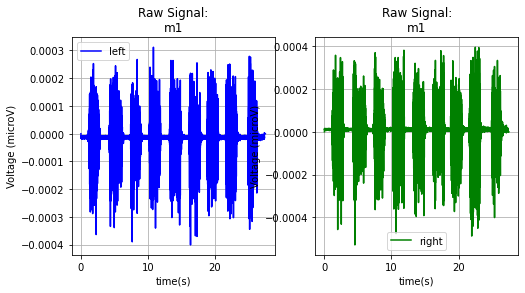

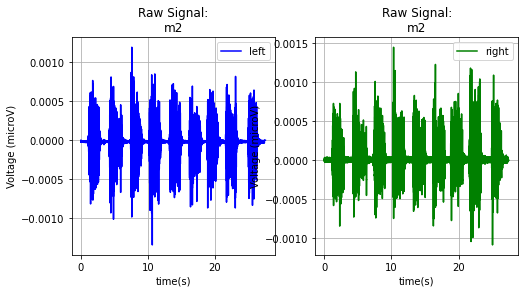

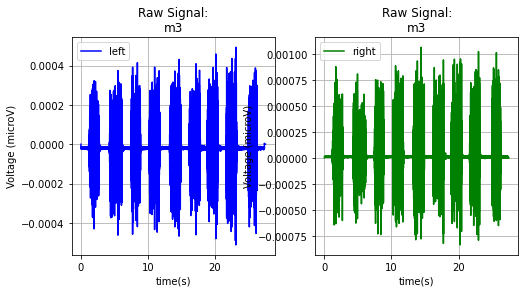

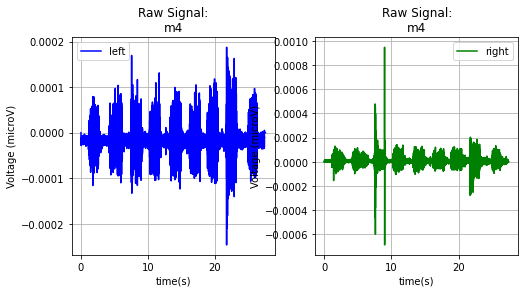

In [28]:
plot_raw_emg()

## Design Bandpass

In [14]:
def bandpass_create(low_band = 3, high_band = 400, order_bp = 2, fs = fs):
    z1, w1 = sp.signal.bessel(order_bp, [low_band,high_band], btype='bandpass',analog = False, output= 'ba', fs = fs)
    return z1, w1, low_band, high_band, fs

In [15]:
z1, w1, low_band, high_band, fs = bandpass_create()

In [16]:
def bandpass_bode(z1 = z1 ,w1 = w1, order_bp = 2,fs = 2000, low_band = low_band, high_band = high_band):
    sys_bp = signal.dlti(z1, w1, dt = 1/fs)
    w_bp, mag_bp, phase_bp = signal.dbode(sys_bp, w = np.logspace(-2,3,100)*2*np.pi)
    w_bp, mag_bp, phase_bp = sys_bp.bode(w = (np.logspace(-2,2.7,100)*2*np.pi)/(fs/2))
    
    low_cut = low_band
    high_cut = high_band

    freq_bp = w_bp/(2*np.pi)

    fig, ax = plt.subplots(2,1,figsize = (6,8))
    ax[0].semilogx(freq_bp, mag_bp)  
    ax[0].set_title(r'Bode Diagram:'+ '\n' + '%snd Order %s and %s Hz BP'%(order_bp,low_band,high_band), fontsize=16)
    ax[0].set_xlabel('Frequency (Hz)')
    ax[0].set_ylabel('Magnitude (dB)')
    #ax[0].autoscale()
    ax[0].grid()

    ax[1].semilogx(freq_bp, phase_bp) 
    ax[1].set_ylabel("Phase (degree)")
    ax[1].set_xlabel("Freq (hz)")
    #ax[1].autoscale()
    ax[1].grid()
    plt.show()

In [18]:
def bandpass_apply(df, z1 = z1, w1 = w1):
    for i in range(1,5):
        df[f'a{i}'] = sp.signal.filtfilt(z1, w1, df[f'a{i}'])
        df[f'b{i}'] = sp.signal.filtfilt(z1, w1, df[f'b{i}'])
    band = df
    return band

In [19]:
band = bandpass_apply(raw_emg)

In [20]:
raw_emg = import_emg()

In [32]:
band.equals(raw_emg)

False

In [30]:
def plot_bandpassed(df):
    for i in range(1,5):
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(df['time'],df[f'a{i}'] , color='blue',label = '%s'%l)
        ax[0].set_title("Rectified Signal:" + "\n" + "%s"%f'm{i}')
        ax[0].set_ylabel("Voltage (microV)")
        ax[0].set_xlabel("time(s)")
        ax[0].grid()
        ax[0].autoscale()
        leg = ax[0].legend()

        ax[1].plot(df['time'],df[f'b{i}'] , color='green', label = '%s'%r)
        ax[1].set_title("Rectified Signal:" + "\n" + "%s"%f'm{i}')
        ax[1].set_ylabel("Voltage (microV)")
        ax[1].set_xlabel("time(s)")
        ax[1].grid()
        ax[1].autoscale()
        leg = ax[1].legend()

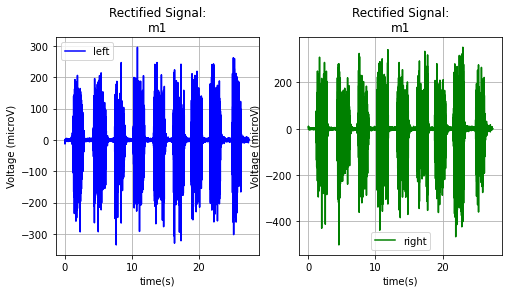

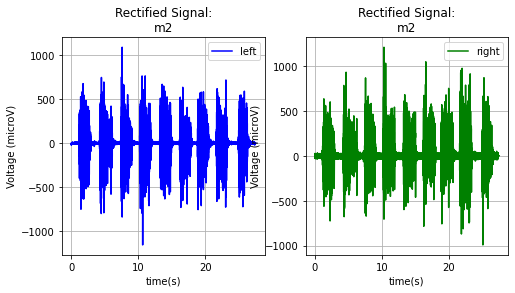

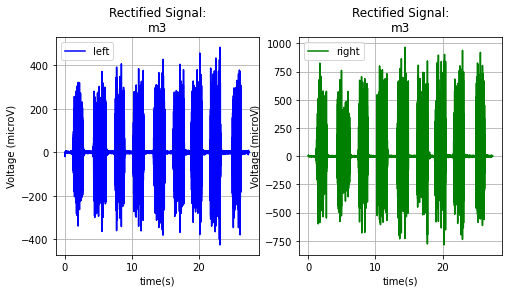

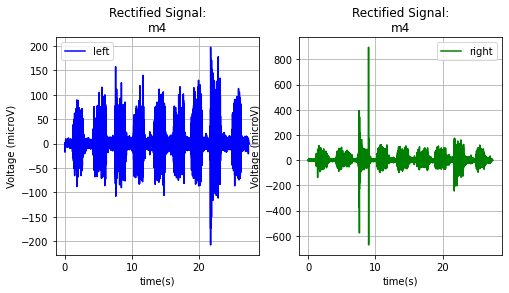

In [31]:
plot_bandpassed(band)

## Rectify signal

In [34]:
def rectify(df = band):
    for i in range(1,5):
        df[f'a{i}'] = np.abs(df[f'a{i}'])
        df[f'b{i}'] = np.abs(df[f'b{i}'])
    rectified = df
    return rectified

In [37]:
def plot_rectified(df):
    for i in range(1,5):
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].plot(df['time'],df[f'a{i}'] , color='blue',label = '%s'%l)
        ax[0].set_title("Rectified Signal:" + "\n" + "%s"%f'm{i}')
        ax[0].set_ylabel("Voltage (microV)")
        ax[0].set_xlabel("time(s)")
        ax[0].grid()
        ax[0].autoscale()
        leg = ax[0].legend()

        ax[1].plot(df['time'],df[f'b{i}'] , color='green', label = '%s'%r)
        ax[1].set_title("Rectified Signal:" + "\n" + "%s"%f'm{i}')
        ax[1].set_ylabel("Voltage (microV)")
        ax[1].set_xlabel("time(s)")
        ax[1].grid()
        ax[1].autoscale()
        leg = ax[1].legend()

## Linear Envelope

In [38]:
def linear_envelope(df, window_size = 100):
    window = np.ones(window_size)/float(window_size)
    for i in range(1,5):
        df[f'a{i}'] = np.sqrt(np.convolve(df[f'a{i}']**2,window,'same'))
        df[f'b{i}'] = np.sqrt(np.convolve(df[f'b{i}']**2,window,'same'))
    rms = df
    return rms

In [40]:
def plot_rms(df):
    for i in range(1,5):
        fig, ax = plt.subplots(2,1,figsize = (8,6))
        ax[0].plot(df['time'], df[f'a{i}'], label = '%s'%l)
        ax[0].set_title(r'RMS:'+ '\n' + '%s'%(f'm{i}'), fontsize=16)
        ax[0].set_xlabel('time(s)')
        ax[0].set_ylabel('EMG (microV)')
        ax[0].autoscale()
        ax[0].grid()
        leg = ax[0].legend()

        ax[1].plot(df['time'], df[f'b{i}'],'g',label = '%s'%r)
        ax[1].set_ylabel("V (microV)")
        ax[1].set_xlabel("time (s)")
        ax[1].autoscale()
        ax[1].grid()
        leg = ax[1].legend()

## Full EMG Processing

In [51]:
def process_emg(df):
    for i in range(1,5):
        df[f'a{i}'] = linear_envelope(rectify(bandpass_apply(df)))[f'a{i}']
        df[f'b{i}'] = linear_envelope(rectify(bandpass_apply(df)))[f'b{i}']
    output = df
    return output

In [244]:
def plot_emg(df):
    df = process_emg(df)
    for i in range(1,5):        
        fig, ax = plt.subplots()
        ax.plot(df['time'], df[f'a{i}'], label = '%s'%l)
        ax.plot(df['time'], df[f'b{i}'],'g',label = '%s'%r)
        ax.set_title(r'Left vs. Right RMS: Smile' +'\n'+'%s'%f'm{i}', fontsize=16)
        ax.set_xlabel('time(s)')
        ax.set_ylabel('Distance (px)')
        ax.grid()
        leg = ax.legend()

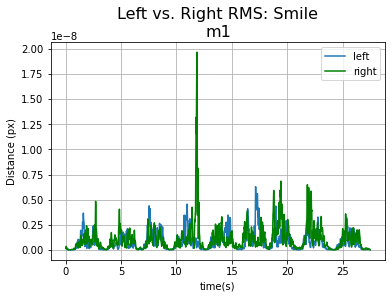

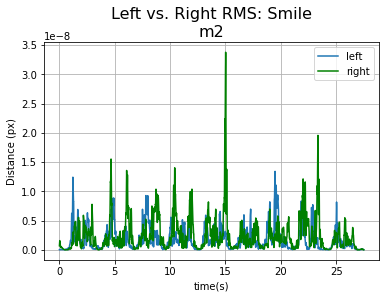

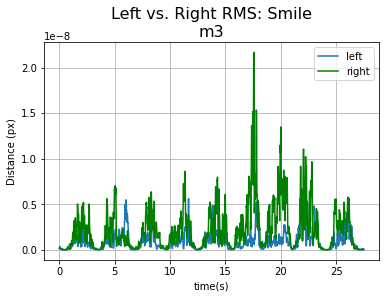

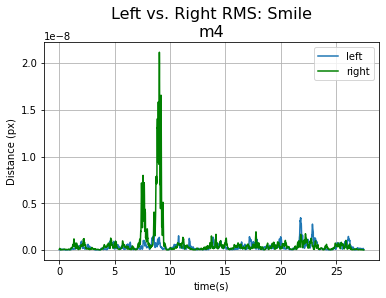

In [245]:
plot_emg(import_emg())

In [225]:
def compare_to_rect(df,rect, window_size = 100, fs = 2000, t_low = 1, t_high = 27):
    window = np.ones(window_size)/float(window_size)
    i = t_low*fs
    j = t_high*fs

    r = "Right"
    l = "Left"
    for idx in range(1,5):
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('EMG (microV)')
        ax1.plot(df['time'], df[f'a{idx}'],label = 'Filtered', color = 'r')
        ax1.set_title('RMS vs. Raw EMG:' +'\n' + '%s'%f'a{i}')
        ax1.grid()
        leg1 = ax1.legend()

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
        ax2.plot(df['time'], rect[f'a{idx}'],label = 'Rect', color = 'b', alpha = 0.2)
        ax2.tick_params(axis='y', labelcolor='r')
        leg2 = ax2.legend()

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

In [251]:
def plot_rect(df,rect):
    df = process_emg(df)
    for i in range(1,5):        
        fig, ax = plt.subplots()
        ax.plot(df['time'], df[f'a{i}'], label = '%s'%'Final')
        ax.plot(df['time'], rect[f'a{i}'],'g',label = '%s'%'Rect')
        ax.set_title(r'Left vs. Right RMS: Smile' +'\n'+'%s'%f'm{i}', fontsize=16)
        ax.set_xlabel('time(s)')
        ax.set_ylabel('Distance (px)')
        ax.grid()
        leg = ax.legend()

## Power EMG

In [261]:
def emg_power(df = rms,fs = 2000):
    t_t_emg = df['time'].iloc[-1]
    N_samples = int(fs*t_t_emg)
    for i in range(1,5):
        df[f'a{i}'] = (df[f'a{i}']**2)/(2*N_samples+1)
        df[f'b{i}'] = (df[f'a{i}']**2)/(2*N_samples+1)
    Power = df
    return Power

## Introducing Kinematic Data - Low Pass

In [175]:
raw_kin = import_kin()

In [185]:
def rawVert(df = raw_kin):
    mouthFrame = df['Frame_number'] 
    
    pos_top = df[['landmark_62_x', 'landmark_62_y']].to_numpy()
    pos_bottom = df[['landmark_66_x', 'landmark_66_y']].to_numpy()
    
    dispVertical = np.linalg.norm(pos_top - pos_bottom, axis=1)
    return dispVertical

def rawHoriz(df = raw_kin):
    mouthFrame = df['Frame_number'] 
    
    pos_derecha = df[['landmark_51_x', 'landmark_51_y']].to_numpy()
    pos_izquierda = df[['landmark_57_x', 'landmark_57_y']].to_numpy()
    dispHorizontal = np.linalg.norm(pos_derecha - pos_izquierda, axis = 1)
    
    return dispHorizontal

In [192]:
mouthFrame = raw_kin['Frame_number']
dispVert = rawVert()
dispHoriz = rawHoriz()

In [193]:
def filter_kin_create(low_pass_frames = 20, fps = 100, lp_order = 2):
    z3, w3 = sp.signal.bessel(lp_order, Wn = low_pass_frames/ (fps / 2), btype = 'lowpass')
    return z3, w3

In [194]:
z3, w3 = filter_kin_create()
def filterHoriz(df = dispHoriz,z3 = z3, w3 = w3):
#     filt_distanceVertical = sp.signal.filtfilt(z3, w3, distanceVertical)
    dispHoriz = sp.signal.filtfilt(z3, w3, df)
    return dispHoriz
def filterVert(df = dispVert,z3 = z3, w3 = w3):
#     filt_distanceVertical = sp.signal.filtfilt(z3, w3, distanceVertical)
    dispVert = sp.signal.filtfilt(z3, w3, df)
    return dispVert

In [197]:
Vert = filterVert()
Horiz = filterHoriz()

In [200]:
def compare_kin(df,raw, window_size = 100, fps = 100, t_low = 1, t_high = 27):
    fig, ax = plt.subplots()
    ax.plot(mouthFrame/fps, raw,'--b',label = "Raw" )
    ax.plot(mouthFrame/fps, df,'--r',label = "Filtered")
    ax.set_title(r'Raw vs Filtered Vertical Distance: Smile ', fontsize=16)
    ax.set_xlabel('time(s)')
    ax.set_ylabel('Distance (px)')
    ax.grid()
    leg = ax.legend()

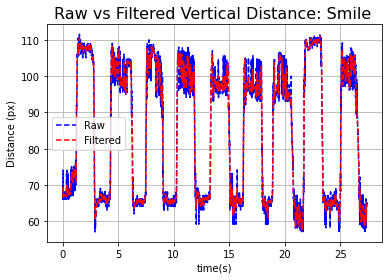

In [201]:
compare_kin(Horiz,dispHoriz)

## Plotting RMS vs Landmarks (Mouth Vertical)

In [297]:
def plot_emg_horiz(df,horiz,fps = 100):
    for i in range(1,5):
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('EMG (microV)')
        ax1.plot(df['time'], df[f'a{i}'],label = '%s'%m3)
        ax1.set_title('RMS vs. Mouth Horizontal distance:' +'\n' + '%s'%f'm{i}')
        ax1.tick_params(axis='y')
        ax1.grid()
        leg1 = ax1.legend()

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
        ax2.plot(mouthFrame/fps, horiz,'--o',label = 'Dist', color = 'r')
        ax2.tick_params(axis='y', labelcolor='r')
        leg2 = ax2.legend()

In [281]:
raw = import_emg()
scaled = set_params_emg(raw)
bandpass_create()
filtered = bandpass_apply(scaled)
rectified = rectify(filtered)
emg = linear_envelope(rectified)

In [282]:
kin_raw = import_kin()
Horiz = rawHoriz(kin_raw)
filter_kin_create()
kin_filt = filterHoriz(Horiz)

In [308]:
plot_emg_horiz(emg,kin_filt)

## Plot Power, RMS, and filtered Kinematic Data: Whole period (Mouth Horizontal)

In [307]:
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('EMG (microV)')
ax1.plot(df['time'], rms_a3,label = '%s'%m3)
ax1.set_title('RMS vs. Mouth Horizontal distance:' +'\n' + '%s'%a3)
ax1.tick_params(axis='y')
leg1 = ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax2.plot(mouthFrame/fps, filt_distanceHoriz,'--o',label = 'Dist', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')
leg2 = ax2.legend()

ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
ax3.plot(df['time'], abs_a3,label = 'Rectified', color = 'b',alpha = 0.3)
ax3.tick_params(axis='y', labelcolor='r')
ax1.grid()
leg3 = ax3.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

NameError: name 'rms_a3' is not defined

## Plot Power, RMS, and filtered Kinematic Data: Whole period (Mouth Horizontal)

In [312]:
def plot_all(df,Power,horiz):
    for i in range(1,5):
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('time (s)')
        ax1.set_ylabel('EMG (microV)')
        ax1.plot(df['time'], df[f'a{i}'],label = 'RMS', color = 'g')
        ax1.set_title('RMS vs. Mouth Vertical distance:' +'\n' + '%s'%a3)
#         ax1.tick_params(axis='y')
        leg1 = ax1.legend()

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
        ax2.plot(mouthFrame/fps, horiz,'--o',label = 'Dist', color = 'r')
        ax2.tick_params(axis='y', labelcolor='r')
        leg2 = ax2.legend()

        ax3 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax3.set_ylabel('Mouth (px)')  # we already handled the x-label with ax1
        ax3.plot(Power['time'], Power[f'a{i}'], label = 'Power', color = 'b',alpha = 0.3)
        ax3.tick_params(axis='y', labelcolor='r')
        ax1.grid()
        leg3 = ax3.legend()

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()

In [310]:
Power = emg_power(emg)

In [313]:
plot_all(emg,Power,kin_filt)

In [ ]:
distanceVertical_average = pd.DataFrame({'Displacement': distanceVertical_average})
  
Power_average = pd.DataFrame({'Power': Power_average,})
  
# the default behaviour is join='outer'
# inner join
  
result = pd.concat([Power_average, distanceVertical_average], axis=1, join='inner')
display(result)

In [ ]:
x = result['Power']
y = result['Displacement']

low_pos = distanceVertical[i11:i11+10].mean()
high_pos = distanceVertical[int((j11-i11)/2 + i11)-10:int((j11-i11)/2 + i11)+10].mean()

power = P_1.mean()

fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('Power')
ax1.set_ylabel('Displacement (px)')
ax1.plot(rms_a3,'--o',color = 'r')
ax1.set_title('Power vs. Mouth Vertical distance:' +'\n' + '%s'%a3)
#plt.tick_params(axis='y')

ax1.scatter((high_pos-low_pos), power)
plt.show()